In [ ]:
# Colab usually has these; wandb is optional
!pip -q install wandb --upgrade

import os, shutil, zipfile, urllib.request, time, math, random
from pathlib import Path

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as T
from torchvision import models

# Reproducibility
seed = 42
random.seed(seed); torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.benchmark = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

In [ ]:
DATA_ROOT = Path("/content/tiny_imagenet")
DATA_ROOT.mkdir(parents=True, exist_ok=True)

def rmrf(p: Path):
    if p.exists():
        shutil.rmtree(p)

def try_git_clone():
    try:
        # This repo already contains Tiny-ImageNet laid out correctly in many forks
        !git clone -q https://github.com/rmccorm4/Tiny-Imagenet-200.git /content/_dl_tmp
        # move into target dir name
        rmrf(DATA_ROOT)
        # Find the actual data directory within the cloned repo
        data_dir = None
        for root, dirs, files in os.walk("/content/_dl_tmp"):
            if "train" in dirs and "val" in dirs:
                data_dir = Path(root)
                break
        if data_dir:
            shutil.move(str(data_dir), str(DATA_ROOT))
            # Clean up the temporary clone directory
            rmrf(Path("/content/_dl_tmp"))
            return True
        else:
            print("Could not find Tiny-ImageNet data within the cloned repository.")
            return False
    except Exception as e:
        print("git clone failed:", e)
        return False

def try_official_zip():
    try:
        url = "http://cs231n.stanford.edu/tiny-imagenet-200.zip"
        zip_path = "/content/tiny-imagenet-200.zip"
        if not os.path.exists(zip_path):
            urllib.request.urlretrieve(url, zip_path)
        with zipfile.ZipFile(zip_path, 'r') as z:
            z.extractall("/content")
        # Final structure: /content/tiny-imagenet-200
        # Move it to DATA_ROOT for consistency
        src = Path("/content/tiny-imagenet-200")
        if DATA_ROOT.exists(): rmrf(DATA_ROOT)
        shutil.move(str(src), str(DATA_ROOT))
        return True
    except Exception as e:
        print("zip download failed:", e)
        return False

ok = try_git_clone()
if not ok:
    print("Falling back to official ZIP...")
    ok = try_official_zip()

print("Data in:", DATA_ROOT)
print("Top-level:", os.listdir(DATA_ROOT))

# --- Fix validation folder if needed (official zip ships val/images + val_annotations.txt) ---
val_dir = DATA_ROOT / "val"
if (val_dir / "images").exists():
    print("Reorganizing val/ into class subfolders...")
    anno = (val_dir / "val_annotations.txt").read_text().strip().splitlines()
    class_map = {}
    for line in anno:
        # filename, wnid, x0, y0, x1, y1
        parts = line.split('\t')
        fname, wnid = parts[0], parts[1]
        class_map[fname] = wnid

    # make class directories and move images
    for fname, wnid in class_map.items():
        (val_dir / wnid).mkdir(exist_ok=True)
        src = val_dir / "images" / fname
        dst = val_dir / wnid / fname
        if src.exists():
            shutil.move(str(src), str(dst))

    # remove images/ after moving
    shutil.rmtree(val_dir / "images", ignore_errors=True)

print("train/ classes:", len(os.listdir(DATA_ROOT/'train')))
print("val/ classes  :", len([d for d in os.listdir(DATA_ROOT/'val') if (DATA_ROOT/'val'/d).is_dir()]))

Could not find Tiny-ImageNet data within the cloned repository.
Falling back to official ZIP...
Data in: /content/tiny_imagenet
Top-level: ['words.txt', 'wnids.txt', 'val', 'train', 'test']
Reorganizing val/ into class subfolders...
train/ classes: 200
val/ classes  : 200


In [ ]:
BATCH_SIZE = 128  # ↓ if OOM: set to 64
NUM_WORKERS = 2

# Strong but safe augmentations for Tiny-ImageNet
transform_train = T.Compose([
    T.Resize((224, 224)),
    T.RandAugment(num_ops=2, magnitude=7),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize((0.485, 0.456, 0.406),
                (0.229, 0.224, 0.225)),
])

transform_val = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize((0.485, 0.456, 0.406),
                (0.229, 0.224, 0.225)),
])

train_ds = torchvision.datasets.ImageFolder(root=str(DATA_ROOT/'train'), transform=transform_train)
val_ds   = torchvision.datasets.ImageFolder(root=str(DATA_ROOT/'val'),   transform=transform_val)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=NUM_WORKERS, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

len(train_ds), len(val_ds)


(100000, 10000)

In [ ]:
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
in_feats = model.fc.in_features
model.fc = nn.Linear(in_feats, 200)
model = model.to(device)

# (Optional) warmup: freeze backbone for first few epochs, then unfreeze (handled in loop)
for p in model.parameters():
    p.requires_grad = True  # we'll still do full fine-tuning, warmup controlled in optimizer if desired


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 121MB/s]


In [ ]:
EPOCHS = 10
BASE_LR = 3e-5

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)   # label smoothing helps with 200 classes
optimizer = optim.AdamW(model.parameters(), lr=BASE_LR, weight_decay=1e-4)

warmup_epochs = 2
total_steps = EPOCHS * math.ceil(len(train_loader))
warmup_steps = warmup_epochs * math.ceil(len(train_loader))

def cosine_warmup(step):
    if step < warmup_steps:
        return float(step) / float(max(1, warmup_steps))
    progress = (step - warmup_steps) / float(max(1, total_steps - warmup_steps))
    return 0.5 * (1.0 + math.cos(math.pi * progress))

scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=cosine_warmup)

scaler = torch.cuda.amp.GradScaler(enabled=(device.type=="cuda"))

# W&B (optional)
USE_WANDB = True
if USE_WANDB:
    import wandb
    wandb.login()
    wandb.init(project="tiny-imagenet-resnet18-colab", config={
        "epochs": EPOCHS, "batch_size": BATCH_SIZE, "lr": BASE_LR, "optimizer": "AdamW",
        "model": "resnet18", "aug": "RandAugment+HF", "loss": "CE+label_smoothing"
    })


/tmp/ipython-input-737403141.py:19: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(device.type=="cuda"))
wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


epoch,▁▂▄▅▇█
lr,██▇▅▃▁
train/acc1,▁▅▇▇██
train/loss,█▄▂▂▁▁
val/acc1,▁▅▇▇██
val/acc5,▁▆▇▇██
val/loss,█▃▂▂▁▁
epoch,6
lr,3e-05
train/acc1,0.71566
train/loss,1.94117


In [ ]:
from time import perf_counter

best_val_acc = 0.0
global_step = 0

def accuracy_topk(logits, targets, ks=(1,5)):
    maxk = max(ks)
    _, pred = logits.topk(maxk, dim=1, largest=True, sorted=True)
    pred = pred.t()
    correct = pred.eq(targets.view(1, -1).expand_as(pred))
    res = []
    for k in ks:
        correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
        res.append((correct_k.item())/targets.size(0))
    return res  # list of floats

for epoch in range(1, EPOCHS+1):
    t0 = perf_counter()
    # -------- Train --------
    model.train()
    train_loss, train_correct, train_count = 0.0, 0, 0

    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device, non_blocking=True), labels.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)
        with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):
            logits = model(imgs)
            loss = criterion(logits, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        scheduler.step()
        global_step += 1

        train_loss += loss.item() * imgs.size(0)
        train_correct += (logits.argmax(1) == labels).sum().item()
        train_count  += imgs.size(0)

    train_acc = train_correct / train_count
    train_loss /= train_count

    # -------- Validate --------
    model.eval()
    val_loss, val_correct, val_count = 0.0, 0, 0
    val_top5_sum = 0.0

    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):
                logits = model(imgs)
                loss = criterion(logits, labels)
            val_loss += loss.item() * imgs.size(0)
            val_correct += (logits.argmax(1) == labels).sum().item()
            acc1, acc5 = accuracy_topk(logits, labels, ks=(1,5))
            val_top5_sum += acc5 * imgs.size(0)
            val_count  += imgs.size(0)

    val_acc  = val_correct / val_count
    val_loss /= val_count
    val_top5 = val_top5_sum / val_count

    dt = perf_counter() - t0
    print(f"Epoch {epoch:03d}/{EPOCHS} | "
          f"Train loss {train_loss:.4f} acc {train_acc*100:5.1f}% | "
          f"Val loss {val_loss:.4f} acc@1 {val_acc*100:5.1f}% acc@5 {val_top5*100:5.1f}% | "
          f"{dt:.1f}s")

    if USE_WANDB:
        import wandb
        wandb.log({
            "train/loss": train_loss, "train/acc1": train_acc,
            "val/loss": val_loss, "val/acc1": val_acc, "val/acc5": val_top5,
            "lr": scheduler.get_last_lr()[0], "epoch": epoch
        })

    # save best
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "/content/best_resnet18_tinyimagenet.pth")
        print(f"  Saved new best (val acc@1 = {best_val_acc*100:.2f}%)")

print("Best val acc@1:", f"{best_val_acc*100:.2f}%")


/tmp/ipython-input-2682749439.py:27: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):
/tmp/ipython-input-2682749439.py:53: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):


Epoch 001/10 | Train loss 1.8269 acc  75.1% | Val loss 1.9152 acc@1  71.5% acc@5  90.6% | 336.3s
  Saved new best (val acc@1 = 71.55%)
Epoch 002/10 | Train loss 1.8124 acc  75.3% | Val loss 1.9120 acc@1  71.7% acc@5  90.6% | 341.6s
  Saved new best (val acc@1 = 71.71%)
Epoch 003/10 | Train loss 1.7669 acc  76.4% | Val loss 1.8931 acc@1  72.0% acc@5  90.8% | 337.4s
  Saved new best (val acc@1 = 72.05%)
Epoch 004/10 | Train loss 1.7101 acc  78.0% | Val loss 1.8775 acc@1  72.6% acc@5  91.0% | 331.0s
  Saved new best (val acc@1 = 72.62%)
Epoch 005/10 | Train loss 1.6538 acc  79.9% | Val loss 1.8661 acc@1  72.8% acc@5  91.3% | 329.7s
  Saved new best (val acc@1 = 72.79%)
Epoch 006/10 | Train loss 1.6046 acc  81.5% | Val loss 1.8562 acc@1  73.2% acc@5  91.4% | 344.7s
  Saved new best (val acc@1 = 73.22%)
Epoch 007/10 | Train loss 1.5680 acc  82.7% | Val loss 1.8502 acc@1  73.3% acc@5  91.3% | 344.1s
  Saved new best (val acc@1 = 73.30%)
Epoch 008/10 | Train loss 1.5414 acc  83.6% | Val loss 

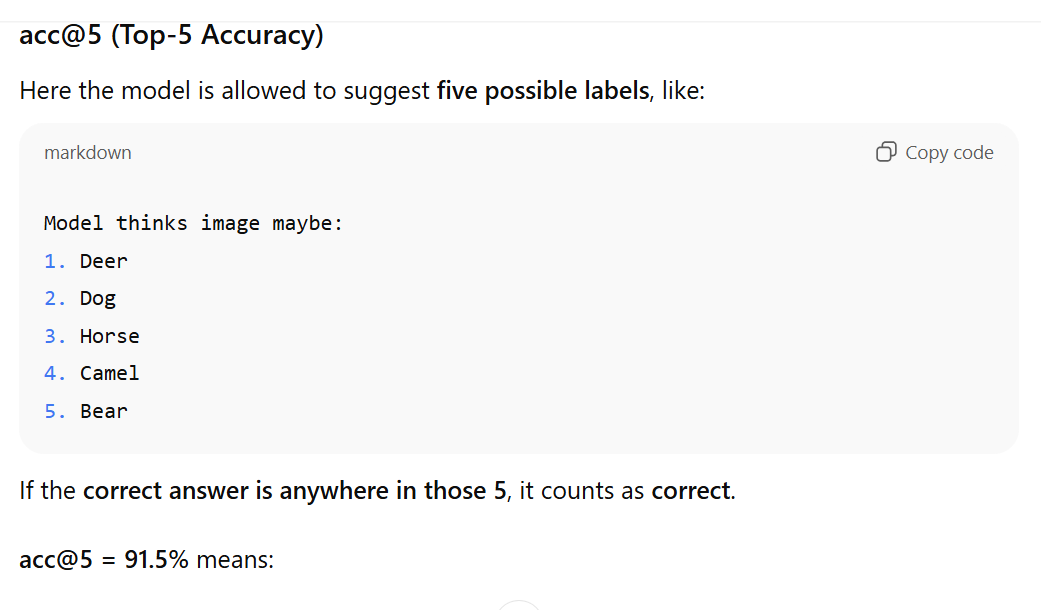

In [ ]:
best_ckpt = "/content/best_resnet18_tinyimagenet.pth"
if os.path.exists(best_ckpt):
    model.load_state_dict(torch.load(best_ckpt, map_location=device))
    model.eval()

# quick final eval
val_correct, val_count, top5_sum = 0, 0, 0.0
with torch.no_grad():
    for imgs, labels in val_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        logits = model(imgs)
        val_correct += (logits.argmax(1) == labels).sum().item()
        acc1, acc5 = accuracy_topk(logits, labels, ks=(1,5))
        top5_sum += acc5 * imgs.size(0)
        val_count += imgs.size(0)
val_acc = val_correct / val_count
val_top5 = top5_sum / val_count
print(f"Final Val acc@1: {val_acc*100:.2f}% | acc@5: {val_top5*100:.2f}%")
print("Checkpoint saved at:", best_ckpt)


Final Val acc@1: 73.69% | acc@5: 91.51%
Checkpoint saved at: /content/best_resnet18_tinyimagenet.pth


In [ ]:
torch.save(model.state_dict(), "best_resnet18_tinyimagenet.pth")


Drifted Accuracy Part

In [ ]:
import torchvision.transforms.functional as F
import cv2
import numpy as np
from PIL import Image


Drift Type simulates

Blur	     -----   Camera out of focus

Gaussian Noise	   ----   Low-light sensor noise

Low Resolution	     -----   Compression / zoomed images


We will compute:

Normal accuracy (already known)

Accuracy under blur

Accuracy under noise

Accuracy under low-res

## Define drift transform functions

In [ ]:
def add_gaussian_noise(img, sigma=0.2):
    np_img = np.array(img).astype(np.float32) / 255.0
    noise = np.random.normal(0, sigma, np_img.shape)
    np_img = np.clip(np_img + noise, 0, 1)
    return Image.fromarray((np_img*255).astype(np.uint8))

def blur(img, ksize=7):
    np_img = np.array(img)
    np_img = cv2.GaussianBlur(np_img, (ksize, ksize), 0)
    return Image.fromarray(np_img)

def low_res(img, factor=4):
    small = img.resize((img.size[0]//factor, img.size[1]//factor))
    return small.resize(img.size)


## Function to evaluate under drift

In [ ]:
def evaluate_with_transform(transform_fn):
    correct = 0
    total = 0
    with torch.no_grad():
        for img_tensor, label in val_ds:
            # Convert PyTorch tensor to PIL Image before applying transform_fn
            img_pil = T.ToPILImage()(img_tensor)
            img_drift = transform_fn(img_pil)
            x = transform_val(img_drift).unsqueeze(0).to(device)
            out = model(x)
            pred = out.argmax(1).item()
            if pred == label:
                correct += 1
            total += 1
    return correct / total

## Run drift evaluation + log to W&B

In [ ]:
normal_acc = val_acc
blur_acc = evaluate_with_transform(blur)
noise_acc = evaluate_with_transform(add_gaussian_noise)
lowres_acc = evaluate_with_transform(low_res)

print(f"Normal Accuracy: {normal_acc*100:.2f}%")
print(f"Blur Accuracy: {blur_acc*100:.2f}%")
print(f"Noise Accuracy: {noise_acc*100:.2f}%")
print(f"Low-Res Accuracy: {lowres_acc*100:.2f}%")

if USE_WANDB:
    wandb.log({
        "drift/normal": normal_acc,
        "drift/blur": blur_acc,
        "drift/noise": noise_acc,
        "drift/lowres": lowres_acc
    })



Normal Accuracy: 73.69%
Blur Accuracy: 5.68%
Noise Accuracy: 2.50%
Low-Res Accuracy: 3.85%
